# Unbinned Poissonian likelihood using NumCosmo on SkySim data

Authors: Céline Combet, Marianna Penna-Lima, Sandro Vitenti

This notebook shows how to:
- Extract data from SkySim using GCRCatalog
- Alternatively, use pre-extracted halo catalogs at NERSC or CC-in2p3
- Set up NumCosmo to perform an unbinned cluster count analysis
- Vizualise the results of the chains

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Extract DM haloes from the SkySim catalog in a given mass and redshift range. 

In [3]:
zmin = 0.
zmax = 1.

## Extract data from `skysim_cat` using GCRCatalog
**NB: Go directly to 1.2 to use pre-extracted halo catalogs **

In [4]:
# import GCRCatalogs
# skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')
# cosmo_ss  = skysim_cat.cosmology
# sky_area = skysim_cat.sky_area

In [5]:
# # Get list of halos in a given redshift and mass range.
# # Can only filter on 'halo_mass' which corresponds to the fof mass (in Msun).
# # Will extract all haloes with halo_mass > mmin_extract now
# # and refine the mass range on M200c, afterwards

# mmin_extract = 1.e13
# dm_halos = skysim_cat.get_quantities(['halo_mass','redshift','baseDC2/sod_halo_mass'],
#                                      filters=[f'halo_mass > {mmin_extract}','is_central==True',
#                                               f'redshift>{zmin}', f'redshift<{zmax}'])
# N_cl = len(dm_halos['halo_mass'])
# print(f'There are {N_cl} halos with Mfof > {mmin_extract:.2e} Msun and z=[{zmin},{zmax}] in {skysim_cat.sky_area} deg2')

## Use the pre-extracted halo catalog stored at CC-IN2P3 or NERSC
You may skip the step above by directly using pre-extracted SkySim halo catalog. These are stored as `hdf5` at CC-IN2P3 and NERSC. These files contains all DM halos of SkySim5000 with $M_{\rm fof}>1\times 10^{13}$M$_\odot$ and $z\in[0,1.2]$. Richness information (not used here) is also available in those files, along with some other halo-related columns. SkySim input cosmology and sky area are also saved as metadata in the file.

You may choose among:
- `skysim_halos_z=0-1.2_mfof_gt_1e13_small.hdf5` for the `small` sky area (~57 deg2)
- `skysim_halos_z=0-1.2_mfof_gt_1e13_image.hdf5` for the `image` sky area (~440 deg2)
- `skysim_halos_z=0-1.2_mfof_gt_1e13_full.hdf5` for the `full` sky area (~5200 deg2)

**Path to access the files at CC-IN2P3:**
`/sps/lsst/users/ccombet/SkySim5000/hdf5`

**Path to access the files at NERSC:**
`/global/u1/c/ccombet/SkySim5000/hdf5`

Comment/uncomment accordingly in the cell below

In [6]:
import pandas as pd

path_to_cat = '/sps/lsst/users/ccombet/SkySim5000/hdf5' # CC-in2p3
# path_to_cat = '/global/u1/c/ccombet/SkySim5000/hdf5' # NERSC

size = 'full' # other options are 'image' (440 deg2) and 'small' (57 deg2)

with pd.HDFStore(os.path.join(path_to_cat,f'skysim_halos_z=0-1.20_mfof_gt_1.00e+13_{size}.hdf5')) as store:
    dm_halos = store['skysim']
    metadata = store.get_storer('skysim').attrs.metadata

cosmo_ss  = metadata['cosmo']
sky_area = metadata['sky_area']
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos with Mfof > 1e13 Msun and z=[0,1.2] in {sky_area} deg2')

There are 2935541 halos with Mfof > 1e13 Msun and z=[0,1.2] in 5264.05 deg2


## Filter on redshift and mass ranges

**Caution**: if using the pre-extracted halo catalog, make sure you do not require here mass and redshift ranges larger than the ones specified above.

NB: SkySim5000 M200c masses are in units of Msun/h

In [7]:
zmin = 0.
zmax = 1.
mmin = 3.e14 # Msun. 
mmax = 1.e15 # Msun

4274 left in the [3.00e+14,1.00e+15[ mass range and [0.00,1.00[ redshift range


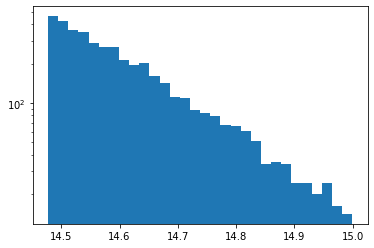

In [8]:
dm_halos['M200c'] = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h # sod_halo_mass = M200,c in Msun/h, needs conversion

filt1 = dm_halos['redshift'] >= zmin
filt2 = dm_halos['redshift'] < zmax
filt3 = dm_halos['M200c'] >= mmin 
filt4 = dm_halos['M200c'] < mmax
filt = filt1 & filt2 & filt3 & filt4

data_m_ss = np.array(dm_halos['M200c'][filt]) # M200,c [Msun]
data_z_ss = np.array(dm_halos['redshift'][filt])

print(f"{len(data_m_ss)} left in the [{mmin:.2e},{mmax:.2e}[ mass range and [{zmin:.2f},{zmax:.2f}[ redshift range")
plt.hist(np.log10(data_m_ss), bins=30);
plt.yscale('log')

# Set up NumCosmo cosmology

In [9]:
Ncm.cfg_init ()
cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new () 
prim = Nc.HIPrimPowerLaw.new () 

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

dist = Nc.Distance.new (2.0)

tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

In [10]:
cosmo.props.H0      = cosmo_ss.H0.value
cosmo.props.Omegab  = cosmo_ss.Ob0
cosmo.props.Omegac  = cosmo_ss.Odm0
cosmo.props.Omegax  = cosmo_ss.Ode0

cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("Omegak", 0.0)

# sigma8 is a derived parameter, to set the right value in NC, need to 
# update the amplitude of the primordial power spectrum
prim.props.n_SA = cosmo_ss.n_s
print(cosmo_ss.sigma8,cosmo.sigma8(psf),cosmo.Omega_k0())

old_amplitude = math.exp (prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log ((cosmo_ss.sigma8 / cosmo.sigma8(psf))**2 * old_amplitude)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))


0.8 0.8490796381176396 0.0
0.8 0.7999999999999999


# Set up fit with NumCosmo

## Mass function, mass and redshift distributions

In [11]:
#
# New multiplicity function 'NcMultiplicityFuncTinkerMean'
#
mulf = Nc.MultiplicityFuncTinker.new ()
#mulf = Nc.MultiplicityFuncBocquet.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta (200.0)
#
# New mass function object using the objects defined above.
#
mf = Nc.HaloMassFunction.new (dist, psf, mulf)

#mf.set_area_sd (skysim_cat.sky_area) # Not sure if this is the way to setup a sky area

In [12]:
#
# New Cluster Mass object
#
lnM_min = math.log (mmin)
lnM_max = math.log (mmax)

# using Log normal distribution
#cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassLnnormal{'lnMobs-min':<%20.15e>, 'lnMobs-max':<%20.15e>}" % (lnM_min, lnM_max))
#cluster_m.props.bias       = 0.0
#cluster_m.props.sigma      = 0.2
#print(cluster_m.lnMobs_min, cluster_m.lnMobs_max, lnM_min, lnM_max)

# no distribution - assumes masses are perfectly known
cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (lnM_min, lnM_max))
print(cluster_m.lnM_min, cluster_m.lnM_max, lnM_min, lnM_max)

33.33480359058475 34.53877639491068 33.33480359058475 34.538776394910684


In [13]:
#
# New Cluster Redshift object
#

# using a global gaussian distribution
#cluster_z = Nc.ClusterRedshift.new_from_name ("NcClusterPhotozGaussGlobal{'pz-min':<%20.15e>, 'pz-max':<%20.15e>, 'z-bias':<0.0>, 'sigma0':<0.03>}" % (zmin, zmax))

# no distribution - assumes redshifts are perfectly known
cluster_z = Nc.ClusterRedshiftNodist(z_min = zmin, z_max=zmax)
print(cluster_z.z_min, cluster_z.z_max, zmin, zmax)

0.0 1.0 0.0 1.0


## Set up objects for the fit

In [14]:
#
# New Cluster abundance object that uses all objects above
#
cad = Nc.ClusterAbundance.new (mf, None)

#
# New NcmData object for number count calculations
#
ncdata = Nc.DataClusterNCount.new (cad)

#
#  Creating a new Modelset and set cosmo as the HICosmo model to be used
#  and cluster_m as the distribution of the mass-observable relation
#
mset = Ncm.MSet.new_array ([cosmo, cluster_z, cluster_m])

In [15]:
#
# Fill ncdata with SkySim masses and redshifts
#

ncdata.set_n_z_obs (1)
ncdata.set_n_z_obs_params (0)
ncdata.set_n_M_obs (1)
ncdata.set_n_M_obs_params (0)

ncdata.set_lnM_true(Ncm.Vector.new_array(np.log (data_m_ss)))
ncdata.set_z_true(Ncm.Vector.new_array(data_z_ss))

# Because we are using true masses and redshifts in this example,
# we replicate the true data in the 'observed' masses and redshift attributes
ncdata.set_lnM_obs (Ncm.Matrix.new_array (data_m_ss,1))
ncdata.set_z_obs (Ncm.Matrix.new_array (data_z_ss,1))

#ncdata.props.area = skysim_cat.sky_area
#mf.set_area_sd (skysim_cat.sky_area)
mf.set_area_sd (sky_area)

ncdata.true_data (True)
ncdata.set_init(True)

# #
# # Save to a fits file
# #
ncdata.catalog_save ("skysim5000_data.fits", True)

In [16]:
# If the catalog already exists, skip previous step and load it directly

# ncdata.catalog_load("../data/skysim5000_data.fits")

## Define free parameters and prepare likelihood

In [17]:
cosmo.props.Omegac_fit    = True
prim.props.ln10e10ASA_fit = True
#cosmo.props.Omegab_fit    = False

# data set
dset = Ncm.Dataset.new ()
dset.append_data (ncdata)


# New likelihood object using dset
lh = Ncm.Likelihood.new (dset)


# Fit for parameters ($\Omega_c$, $\ln A_s$) --> ($\Omega_m$, $\sigma_8$)

## Simple fit
It output of the fit will be used as starting point for the MCMC, afterwards.

In [18]:
#
#  Creating a Fit object of type NLOPT using the fitting algorithm ln-neldermead to
#  fit the Modelset mset using the Likelihood lh and using a numerical differentiation
#  algorithm (NUMDIFF_FORWARD) to obtain the gradient (if needed).
#
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

fit.run (Ncm.FitRunMsgs.SIMPLE)

#
# Printing fitting informations.
#
fit.log_info ()
fit.obs_fisher ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#...............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:19.7345270
#  iteration            [000064]
#  function evaluations [000066]
#  gradient evaluations [000000]
#  degrees of freedom   [004272]
#  m2lnL     =    -2917.96093966036 (    -2917.9609 )
#  Fit parameters:
#     0.214785892265195    3.13239998742583    
#----------------------------------------------------------------------------------
# Data used:
#   - Cluster abundance unbinned
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -        

In [19]:
print (cosmo.props.Omegac, cosmo_ss.Odm0)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))

0.21478589226519484 0.21999999999999997
0.8 0.8159636154351697


## MCMC
At CC-in2p3, using the jupyter notebook plateform, the cell below with the uncommented settings for the MCMC, runs in ~ 80 min.

In [20]:
#
# Setting single thread calculation.
#
Ncm.func_eval_set_max_threads (4)
Ncm.func_eval_log_pool_stats ()

#
# Additional functions as we want the chains for sigma8 and Omegam, which are derived parameters
#
mfunc_oa = Ncm.ObjArray.new ()

mfunc_sigma8 = Ncm.MSetFuncList.new ("NcHICosmo:sigma8", psf)
mfunc_Omegam = Ncm.MSetFuncList.new ("NcHICosmo:Omega_m0", None)

mfunc_oa.add (mfunc_sigma8)
mfunc_oa.add (mfunc_Omegam)

# Check the best fit of the previous simple fit procedure
print (mfunc_sigma8.eval0 (mset))
print (mfunc_Omegam.eval0 (mset))

#
# New Gaussian prior to provide the initial points for the chain.
# It was created with size 0 (number of parameters), but once 
# initialized with mset the correct size is assigned. 
#
# The initial sampler will use a diagonal covariance with the
# diagonal terms being the parameters scale set by each model.
#
init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0) #1

#
# Creates the ESMCMC walker object, this object is responsible
# for moving the walkers in each interation. The 'stretch' move
# is affine invariant and therefore gives good results even for
# very correlated parametric space. The 'APES' move...
# 
sampler = 'apes'
#sampler  = 'stretch'
nwalkers = int (math.ceil (500)) #500
#ssize    = 1000000 

if sampler == 'apes':
  walker = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
elif sampler == "stretch":
  walker = Ncm.FitESMCMCWalkerStretch.new (nwalkers, mset.fparams_len ())

#
# The methods below set the walk scale, which controls the size of the
# step done between two walkers and circumscribe the walkers inside
# the box defined by the parameters inside the mset object.
#
#walker.set_scale (3.0)
#walker.set_box_mset (mset)
#
# Initialize the ESMCMC object using the objects above. It will
# use 500 walkers, i.e., each point in the MCMC chain contains
# 500 points in the parametric space. Each step uses the last point
# in the chain (the last 50 parametric points) to calculate the
# proposal points.
#
esmcmc  = Ncm.FitESMCMC.new_funcs_array (fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa)

#
# These methods enable the auto-trim options on ESMCMC. This option 
# makes the sampler check the chains' health and trim any unnecessary 
# burn-in part. We set the number of divisions to 100 so we test the
# chains in blocks of n/100. The last method asserts that each 2min
# the catalog will be checked.
#
#esmcmc.set_auto_trim (True)
#esmcmc.set_auto_trim_div (100)
#esmcmc.set_max_runs_time (2.0 * 60.0)
#esmcmc.set_nthreads (4)
esmcmc.set_data_file (f"NC_%s_st_%d_true_{size}.fits" % (sampler, nwalkers))

#
# Running the esmcmc, it will first calculate 1000 points, after that
# it will estimate the error in the parameters mean. Using the current
# errors the algorithm tries to calculated how many extra steps are 
# necessary to obtain the required error `10^-3' in every parameters,
# and it will run such extra steps. It will repeat this procedure
# until it attains the required error in every parameter.
# 
#
esmcmc.start_run ()
#esmcmc.run (10)
esmcmc.run_lre (50, 1.e-3)
esmcmc.end_run ()

#
# Calculates the parameter means and covariance and set it into 
# the fit object and then print.
# 
esmcmc.mean_covar ()
fit.log_covar ()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     32
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      4
0.8159636154351697
0.25958589226519485
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0000.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 2796436162.
# NcmMSetCatalog: Current mean:   30518        0.92636      0.25935      0.21455      3.2588     
# NcmMSetCatalog: Current msd:    1791.9       0.015674     0.00044997   0.00044997   0.031778   
# NcmMSetCatalog: Current sd:     40069        0.35048      0.010062     0.010062     0.71058    
# NcmMSetCatalog: Current var:    1.6055e+09   0.12283      0.00010124   0.00010124   0.50493    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Cu

In [21]:
mcat = esmcmc.peek_catalog ()

## Visualize results

### Directly from the `mcat` object

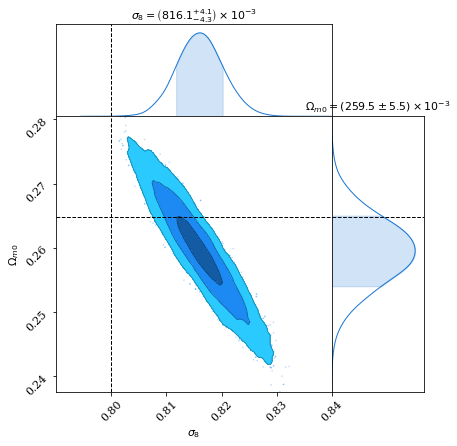

In [61]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

nwalkers = mcat.nchains ()
m2lnL = mcat.get_m2lnp_var ()

# Use nwalkers * 10 as burning length
burn = nwalkers * 10
rows = np.array ([mcat.peek_row (i).dup_array () for i in range (burn, mcat.len ())])
params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]

posterior = -0.5 * rows[:,m2lnL]

rows   = np.delete (rows,   m2lnL, 1)
params = np.delete (params, m2lnL, 0)

# Selecting sigma8 and Omegam, i.e. indices [0,1]
# (Omegac and ln10e10ASA are indices[2,3]
indices = [0,1]

rows   = rows[:,indices]
params = params[indices]

c.add_chain(rows, posterior = posterior, parameters=list(params))
c.configure (kde = True, label_font_size=11, cloud=True, sigma2d=True, sigmas = [1, 2, 3], spacing = 0.0, tick_font_size=11, usetex=False)

plot_args = {}
plot_args['truth'] = [cosmo_ss.sigma8, cosmo_ss.Om0]
fig = c.plotter.plot(**plot_args,extents={params[0]: (0.79,0.84)})

fig.set_size_inches(6, 6)


### Replot the results from the chain `.fits` file
If the MCMC has already run, use the cells below to simply replot the output

In [34]:
import astropy.io.fits as fits

In [35]:
hdu = fits.open(f"NC_%s_st_%d_true_{size}.fits" % (sampler, nwalkers))

In [36]:
hdu[1].data

FITS_rec([(-2825.46383261, 0.790842  , 0.27611251, 0.23131251, 2.96891498),
          (19892.20171927, 0.59280272, 0.2638474 , 0.2190474 , 2.46636013),
          (10041.44671378, 0.64452403, 0.26379107, 0.21899107, 2.63401355),
          ...,
          (-2915.54732573, 0.82035681, 0.25661336, 0.21181336, 3.1624246 ),
          (-2915.50993048, 0.82166196, 0.25131219, 0.20651219, 3.20092321),
          (-2916.21317881, 0.8151467 , 0.26316286, 0.21836286, 3.10766535)],
         dtype=(numpy.record, [('NcmFit:m2lnL', '>f8'), ('sigma8', '>f8'), ('Omega_m0', '>f8'), ('NcHICosmo:Omegac', '>f8'), ('NcHIPrim:ln10e10ASA', '>f8')]))

In [48]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
posterior = -0.5 * hdu[1].data['NcmFit:m2lnL']
rows = np.array ([hdu[1].data[i] for i in range (burn, hdu[1].header['NAXIS2'])])
params = ["$" + hdu[1].header['ASYMB2']+"$", "$"+ hdu[1].header['ASYMB3']+"$" ]


In [49]:
# Selecting sigma8 and Omegam, i.e. indices [0,1]
# (Omegac and ln10e10ASA are indices[3,4]
indices = [1,2]
rows[:,indices]
posterior = -0.5 * hdu[1].data['NcmFit:m2lnL']

In [50]:
c.add_chain(rows[:,indices], posterior = posterior[burn::], parameters=list(params))
c.configure (kde = True, label_font_size=11, cloud=True, sigma2d=True, sigmas = [1, 2, 3], 
             spacing = 0.0, tick_font_size=11, usetex=False)


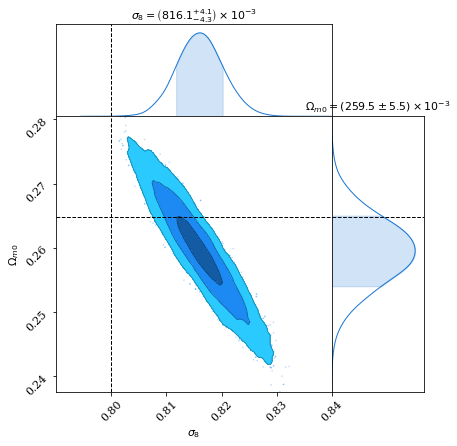

In [62]:
plot_args = {}
plot_args['truth'] = [cosmo_ss.sigma8, cosmo_ss.Om0]

fig = c.plotter.plot(**plot_args,extents={params[0]: (0.79,0.84)})

fig.set_size_inches(6, 6)


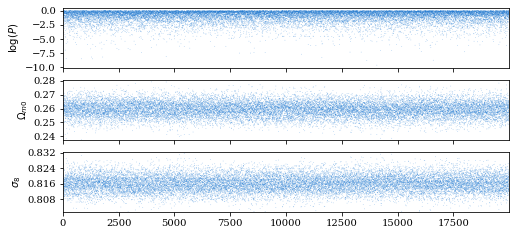

In [46]:
fig = c.plotter.plot_walks()